In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")


from dataloaders import data_set, data_dict
import torch
import yaml
import os
import pandas as pd
import matplotlib.pyplot as plt
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [2]:
args = dotdict()   

args.freq_save_path   = r"/mnt/c/Users/Murat/Desktop/Bachelor/Freq_data"
args.window_save_path = r"/mnt/c/Users/Murat/Desktop/Bachelor/Sliding_window"
args.root_path        = r"/mnt/c/Users/Murat/Desktop/Bachelor/datasets"

args.drop_transition  = False

args.batch_size       = 128
args.shuffle          = True
args.drop_last        = False
args.train_vali_quote = 0.85

In [3]:
# dataset to be used
args.data_name           =  "hapt"  # rw hapt

# whether to calculate augmentation difference
args.difference          =  False 

# whether to do augmentation  filtering
args.filtering           =  False

# whether to do augmentation  magnitude
args.magnitude           =  False
args.weighted_sampler    =  False


# whether to do wavelet_filtering and configuration
args.wavelet_filtering   = False
args.number_wavelet_filtering = 10

# how to normalize the data
args.datanorm_type       =  "standardization" # None ,"standardization", "minmax"

# select position on body
args.pos_select          = None

# select sensor
args.sensor_select       = None



args.representation_type = "time"
args.exp_mode            = "LOCV"

config_file = open('../../configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]
args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.c_in            =  config["num_channels"]

args.input_length    =  args.windowsize

# input information
if args.wavelet_filtering:
    
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1

In [4]:
# load the dataset
dataset = data_dict[args.data_name](args)

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------


In [5]:
color_map = {"acc_x":'#1f77b4',"acc_y":'#ff7f0e', "acc_z":'#2ca02c',
              "gyro_x":'#d62728',"gyro_y":'#9467bd',"gyro_z":'#8c564b'}
acc_cols = ["acc_x","acc_y","acc_z"]
gyro_cols = ["gyro_x","gyro_y","gyro_z"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [17]:
# index of the sample to be used
index = 1000
# 
window_start, window_end = dataset.train_slidingwindows[index][1:]
window_value = dataset.data_x.iloc[window_start:window_end,1:-1]

label_map = {}
for item in dataset.label_map:
    label_map[item[0]] = item[1]
window_label = dataset.data_y.iloc[window_start:window_end].mode().loc[0]
label = label_map[window_label]

# rename sensors 
window_value.columns = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]

# reset index to begin with 0
window_value.reset_index(drop=True, inplace=True)

print(label)

WALKING_UPSTAIRS


Accelerometer Data

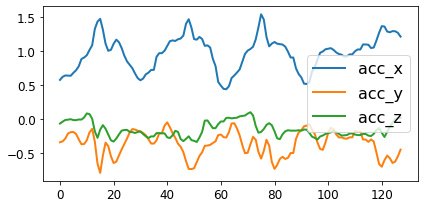

In [27]:
plt.figure(figsize=(6,3))
for col in acc_cols:
    plt.plot(window_value[col],c = color_map[col], linewidth=2,label = col)
plt.legend(fontsize=16)
# plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\original_acc.png",dpi=800,transparent=True)
plt.show()

Gyroscope Data

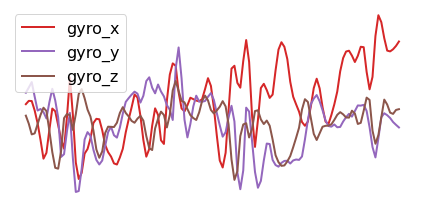

In [28]:
plt.figure(figsize=(6,3))
for col in gyro_cols:
    plt.plot(window_value[col],c = color_map[col], linewidth=2,label = col)
plt.legend(fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\original_gyro.png",dpi=800,transparent=True)
plt.show()

Channel Augmentation

In [29]:
from scipy import signal
fc1 = 0.3  # Cut-off frequency of the filter
w1 = fc1 / (50 / 2) # Normalize the frequency

fc2 = 20  # Cut-off frequency of the filter
w2 = fc2 / (50 / 2) # Normalize the frequency

b1, a1 = signal.butter(2, w1, 'low')
b2, a2 = signal.butter(2, [w1,w2], 'band')

Calculating difference & Separating body and gravitation

In [ ]:
grav_acc_xyz = {}
body_acc_xyz = {}
for col in acc_cols:
    acc = window_value[col]
    b1, a1 = signal.butter(2, w1, 'low')
    grav = signal.filtfilt(b1, a1, acc)
    b2, a2 = signal.butter(2, [w1,w2], 'band')
    body = signal.filtfilt(b2, a2, acc)

    diff = acc.diff()
    plt.figure(figsize=(6,2))
    plt.plot(grav, label='grav_'+col,c = color_map[col], linewidth=2)
    plt.legend(fontsize=12)
    #plt.axis('off')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('grav_'+col),dpi=300,transparent=True)
    plt.show()    

    plt.figure(figsize=(6,2))
    plt.plot(body, label='body_'+col,c = color_map[col], linewidth=2)
    plt.legend(fontsize=12)
    #plt.axis('off')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('body_'+col),dpi=300,transparent=True)
    plt.show()

    plt.figure(figsize=(6,2))
    plt.plot(diff, label='diff_'+col,c = color_map[col], linewidth=2)
    plt.legend(fontsize=12)
    #plt.axis('off')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('diff_'+col),dpi=300,transparent=True)
    plt.show()

    grav_acc_xyz[col] = grav
    body_acc_xyz[col] = body

Define magnitude function

In [ ]:
import numpy as np
import math
def mag_3_signals(x,y,z):# magnitude function redefintion
    return np.array([math.sqrt((x[i]**2+y[i]**2+z[i]**2)) for i in range(len(x))])

Calculate magnitude for gravity channel

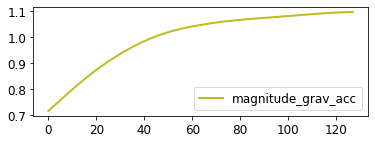

In [32]:
cols = list(grav_acc_xyz.keys())
grav_acc = mag_3_signals(grav_acc_xyz[cols[0]],grav_acc_xyz[cols[1]], grav_acc_xyz[cols[2]])

plt.figure(figsize=(6,2))
plt.plot(grav_acc, label='magnitude_grav_acc',c = '#bcbd22', linewidth=2)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('magnitude_grav_acc'),dpi=300,transparent=True)
plt.show()

Calculate magnitude for body channel

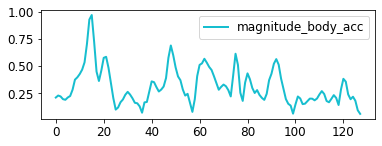

In [33]:
cols = list(body_acc_xyz.keys())
grav_acc = mag_3_signals(body_acc_xyz[cols[0]],body_acc_xyz[cols[1]], body_acc_xyz[cols[2]])

plt.figure(figsize=(6,2))
plt.plot(grav_acc, label='magnitude_body_acc',c = '#17becf', linewidth=2)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('magnitude_body_acc'),dpi=300,transparent=True)
plt.show()

Mixup Augmentation

Select Another Sample

WALKING


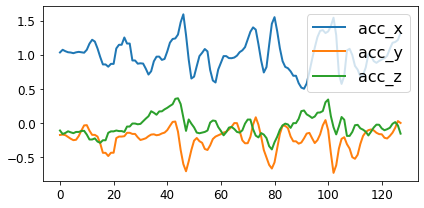

In [36]:
# select the sample with index
index = 106

window_start, window_end = dataset.train_slidingwindows[index][1:]
window_value_2 = dataset.data_x.iloc[window_start:window_end,1:-1]
window_label_2 = dataset.data_y.iloc[window_start:window_end].mode().loc[0]
label_2 = label_map[window_label_2]
    
window_value_2.columns = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
window_value_2.reset_index(drop=True, inplace=True)
print(label_2)

plt.figure(figsize=(6,3))
for col in acc_cols:
    plt.plot(window_value_2[col],c = color_map[col], linewidth=2,label = col)
plt.legend(fontsize=16)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
#plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\original_acc.png",dpi=300,transparent=True)
plt.show()